## Проект e-commerce: вариант 1

In [2]:
# Подгружаем библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from urllib.parse import urlencode
from operator import attrgetter
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Общие настройки для графиков
sns.set(
    rc={
        "figure.figsize": (12, 8), #размер графика - 12 дюймов в ширину, 8 в длину
        "axes.titlesize": 20, #размер заголовка 
        "axes.labelsize": 14, #размер подписей осей
        "xtick.labelsize": 13, #размер подписей чёрточек на x-оси
        "ytick.labelsize": 13, #размер подписей чёрточек на y-оси
    }
)

sns.set_style("whitegrid") #тема фона, белая со штриховкой

In [4]:
# ссылки на файлы

customers_dataset_url = "https://disk.yandex.ru/d/QXrVDUoQvFhIcg"
orders_dataset_url = "https://disk.yandex.ru/d/0zWmh1bYP6REbw"
order_items_dataset_url = "https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg"

In [5]:
# Функция для запроса к Яндексу.Диску:

def download_yandex_disk(public_key):
    """
    Эта функции предназначена для загрузки файла с Яндекс.Диска по его публичной ссылке (public_key).  
    В базовый URL, который будет использоваться для запроса на сервер Яндекс.Диска, добавляется параметр public_key,
    преобразованный в словарь и закодированный функцией urlencode. 
    С помощью библиотеки requests функция отправляет GET-запрос по сформированному URL и получает ответ в JSON формате. 
    Извлечение файла происходит путем доступа к ключу "href". 
    Функция возвращает полученную ссылку на загрузку файла с Яндекс.Диска.
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [6]:
# Загружаем данные

customers = pd.read_csv(download_yandex_disk(customers_dataset_url)) # таблица с уникальными идентификаторами пользователей
orders = pd.read_csv(download_yandex_disk(orders_dataset_url))       # таблица заказов
items = pd.read_csv(download_yandex_disk(order_items_dataset_url))   # товарные позиции, входящие в заказы

In [7]:
# Проведем  преобразование колонок с датами

orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp, format='%Y-%m-%d %H:%M:%S')
orders['order_approved_at'] = pd.to_datetime(orders.order_approved_at, format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_carrier_date'] = pd.to_datetime(orders.order_delivered_carrier_date, format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date, format='%Y-%m-%d %H:%M:%S')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date, format='%Y-%m-%d %H:%M:%S')

### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [129]:
# Добавляем в таблицу заказов информацию с уникальными идентификаторами пользователей, 
# объединяя по колонке c позаказным идентификатором пользователя (customers_id)

orders_customers = orders.merge(customers, on = ['customer_id'])

##### Формально покупкой стоит считать передачу владения товара, которое переходит к покупателю в момент передачи товара, а не в момент оплаты, если в договоре не прописано иного. Исходя из этого, верно подразумевать под покупками заказы, где товар был оплачен и доставлен пользователю. Однако, мы так же рассмотрим иную ситуацию, где под покупками будут  в том числе и заказы в обработке, по которым осуществлена оплата. 

In [130]:
# Фильтруем по статусу заказа 'delivered'
# Группируем по уникальному идентификатору пользователя
# Считаем количества заказов, совершенное каждым пользователем
# Фильтруем по количеству заказов, оставляя только пользователей с одним заказом
# Cчитаем количество пользователей

orders_customers.query('order_status == "delivered"') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id' : 'count'}) \
    .query('order_id == 1') \
    .agg({'order_id' : 'sum'})

order_id    90557
dtype: int64

##### 90557 - количество пользователей совершивших одну покупку, на основе данных о доставленных заказах.

In [131]:
orders_customers.query('order_status == "delivered" and order_approved_at.isna() == False') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id' : 'count'}) \
    .query('order_id == 1') \
    .agg({'order_id' : 'sum'})

order_id    90545
dtype: int64

##### Если мы рассмотрим количество пользователей совершивших покупку один раз, на основе данных о доставленных заказах с наличием информации о времени подтверждения оплаты заказов, их будет всего на 12 меньше.

##### Всего доставленных заказов без информации о времении подтверждения оплаты заказов - 14. Анализ времени подтверждения оплаты заказов и времени доставки, приводит к выводу, что помимо предварительной оплаты заказов возможна оплата заказов в момент доставки или постоплата. На основании этого сложно утверждать, являются ли эти заказы до сих пор неоплаченными или информация о времени подтверждении оплаты утеряна. 

In [132]:
orders_customers \
    .query('order_status not in ("canceled", "unavailable") and order_approved_at.isna() == False') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id' : 'count'}) \
    .query('order_id == 1') \
    .agg({'order_id' : 'sum'})

order_id    92087
dtype: int64

##### Если мы учтём доставленные заказы и заказы в обработке, по которым осуществлена оплата, но еще не доставлены покупателю и не будем учитывать заказы, которые были отменены покупателем ('canceled') или продавцом ('unavailable'), то число покупателей, совершивших покупку один раз, составит 92087.

In [133]:
# Количество завершенных заказов - оплаченные и доставленные заказы

number_of_completed_orders = orders_customers \
    .query('order_status not in ("canceled", "unavailable") and order_approved_at.isna() == False') \
    .order_id.nunique()

# Общее количество заказов
number_of_orders = orders_customers \
    .order_id.nunique() 

# Отношение числа завершенных заказов ко всем заказам
R = round(number_of_completed_orders/number_of_orders, 3)
R

0.987

##### Далее при анализе для удобства мы будем опираться на завершенные заказы ( оплаченные и доставленные), поскольку они составляю порядка 98.7% от всего заказов.

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [134]:
# Посчитаем количество заказов недоставленных заказов с разным статусом

orders \
    .query('order_status != "delivered"') \
    .groupby('order_status', as_index = False) \
    .agg({'order_id' : 'count'}) \

,order_status,order_id
0,approved,2
1,canceled,625
2,created,5
3,invoiced,314
4,processing,301
5,shipped,1107
6,unavailable,609


##### Статусы заказов "created", "approved", "invoiced, "processing", "shipped" относяться к заказам в процессе исполнения. Рассмотрим заказы со статусом "canceled" (вероятно подразмевается отмена покупателем) и со статусом "unavailable ( отсутсвие товара у продавца или невозможность поставить по другим причинам)

##### При анализе недоставленных заказов можно опираться на один из двух временных рядов - время создание заказа или предположительное время доставки заказа. Поскольку создание заказа подразумевается как целевое действие, правильнее будет ориентироваться на время создание заказа.

In [135]:
# Создадим колонку с годом и месяцом предполагаемой доставки заказа
orders['order_purchase_month'] = orders.order_purchase_timestamp.dt.to_period("M")

In [185]:
# Считаем количество отмененных и недоступных заказов за каждый месяц

undelivered_per_month = orders.query('order_status in ("canceled", "unavailable")') \
    .groupby(['order_purchase_month', 'order_status'], as_index = False) \
    .agg({'order_id' : 'count'}) \
    .pivot(index = 'order_purchase_month', columns = 'order_status', values= 'order_id').fillna(0).reset_index()
undelivered_per_month

order_status,order_purchase_month,canceled,unavailable
0,2016-09,2.0,0.0
1,2016-10,24.0,7.0
2,2017-01,3.0,10.0
3,2017-02,17.0,45.0
4,2017-03,33.0,32.0
5,2017-04,18.0,9.0
6,2017-05,29.0,31.0
7,2017-06,16.0,24.0
8,2017-07,28.0,52.0
9,2017-08,27.0,32.0


##### Период создания заказов в нашем датафрейме -  с 04.09.2016 года по 17.10.2018 года. Стоит обратить внимание, что строк соответвующих декабрю и ноябрю 2016 года в таблице нет. Более того первый и последний месяц не полные.  Можем их откинуть при анализе или добавить нормировку на количество дней.

In [186]:
# Добавим недостающие строки

s1 = {'order_purchase_month':pd.to_datetime('2016-11', format='%Y-%m').to_period("M"),'canceled':0,'unavailable':0}
s2 = {'order_purchase_month':pd.to_datetime('2016-12', format='%Y-%m').to_period("M"),'canceled':0,'unavailable':0}
undelivered_per_month = undelivered_per_month.append([s1,s2], ignore_index=True).sort_values(by = "order_purchase_month").reset_index(drop = True)



In [187]:
# Cреднее количество отмененых и недоступных заказов в месяц на основе времени создания заказа
undelivered_per_month \
    .drop(labels = [0,23], axis = 0) \
    .agg({'canceled' : 'mean', 'unavailable' : 'mean'}) \
    .reset_index() \
    .rename(columns = {'index': 'status' , 0: 'mean'}) \
    .round(2)

,status,mean
0,canceled,22.46
1,unavailable,25.08


##### C учетом краевых случаев можно ввести альтернативный вариант расчета среднего в месяц с нормировкой на количестве дней

In [188]:
undelivered_per_month_mod = undelivered_per_month
undelivered_per_month_mod.loc[0, "canceled"] = undelivered_per_month.iloc[0]["canceled"]*26/30
undelivered_per_month_mod.loc[23, "canceled"] = undelivered_per_month.iloc[0]["canceled"]*17/31

In [189]:
undelivered_per_month_mod \
    .agg({'canceled' : 'mean', 'unavailable' : 'mean'}) \
    .reset_index() \
    .rename(columns = {'index': 'status' , 0: 'mean'}) \
    .round(2)

,status,mean
0,canceled,20.83
1,unavailable,23.42


### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [192]:
# Отфильтруем завершенные заказы

orders_items = orders \
    .query('order_status == "delivered" and order_approved_at.isna() == False') \
    .merge(items, on = ['order_id'])


In [193]:
# Создаем колонку с днями недели, когда бы заказан товар

orders_items['weekday'] = pd.to_datetime(orders_items.order_purchase_timestamp).dt.strftime('%A')

In [195]:
# Формируем таблицу, в которой отображена информация сколько раз был продан,
# тот или иной товар в определенный день недели за весь рассматриваемый период

sales_by_weekday = orders_items \
    .groupby(['product_id', 'weekday'], as_index = False)\
    .agg({'order_id' : 'count'}) \
    .rename(columns ={'order_id': 'N'}) \
    .pivot(index = 'product_id', columns = 'weekday', values= 'N')\
    .fillna(0) \
    .reset_index()

In [196]:
# Упорядочим колонки с днями недели

sales_by_weekday = sales_by_weekday[['product_id', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
sales_by_weekday.head()

weekday,product_id,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00088930e925c41fd95ebfe695fd2655,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0009406fd7479715e4bef61dd91f2462,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,000b8f95fcb9e0096488278317764d19,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,000d9be29b5207b54e86aa1b1ac54872,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [197]:
# Альтернативная таблицой с информацией о дне недели, в который товар заказывается чаще всего
# При равенстве значений для нескольких дней недели, выбирается первое встреченое с таким максимальным значение

most_selling_weekday = orders_items \
    .groupby(['product_id', 'weekday'], as_index = False)\
    .agg({'order_id' : 'count'}) \
    .rename(columns ={'order_id': 'N'}) \
    .groupby(['product_id'], as_index = False) \
    .agg({'N' : 'max', 'weekday': 'first'})\
    .sort_values(by = 'N', ascending = False)

most_selling_weekday.head()

,product_id,N,weekday
8428,422879e10f46682990de24d770e7f83d,93,Friday
19288,99a4788cb24856965c36a24e339b6058,91,Friday
21615,aca2eb7d00ea1a7b8ebd4e68314663af,89,Friday
10614,53b36df67ebb7c41585e8d54d6772e08,76,Friday
6925,368c6c730842d78016ad823897a372db,67,Friday


#### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

##### В данном задании, как и в предыдущем, мы будем опираться на время создания заказа и брать в расчет только оплаченные доставленные заказы и заказы в обработке. 

In [237]:
# Добавим колонку с месяцем, когда был сделан заказ 

orders_customers['order_purchase_month'] = orders_customers.order_purchase_timestamp.dt.to_period('M')

In [238]:
# Создадим таблицу с количеством покупок в месяц для каждого пользователя


purchases_by_customer = orders_customers \
    .query('order_status == "delivered" and order_approved_at.isna() == False') \
    .groupby(['order_purchase_month', 'customer_unique_id'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'number_of_purchases'}) \
    .sort_values(by = 'order_purchase_month')

In [239]:
# Добавляем колонку с количеством недель в месяце

purchases_by_customer['weeks_in_month'] = (purchases_by_customer.order_purchase_month.dt.daysinmonth / 7).round(2)
purchases_by_customer

,order_purchase_month,customer_unique_id,number_of_purchases,weeks_in_month
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,1,4.29
167,2016-10,a36dfd7f887f03e4818a77b11784236e,1,4.43
168,2016-10,a45afad7fcd7b8fa4fae020780a05b55,1,4.43
169,2016-10,a5afc2fc6cbdb37998250ef5c42eab15,1,4.43
170,2016-10,a5cad0a33504fb5b9725ac33ed686359,1,4.43
...,...,...,...,...
90968,2018-08,5690fe2160726cc9d85921d03beefb25,1,4.43
90967,2018-08,568c55c1df1dd77d62d3c93f7d03c58b,1,4.43
90966,2018-08,56741af99968c78688e558b5551c68ec,1,4.43
90964,2018-08,566ef46eec03ac4a0e424357fa71db1e,1,4.43


In [240]:
# Введем поправку количества недель для заказа сделанного в неполный первый месяц

purchases_by_customer.loc[0, 'weeks_in_month'] = 3.71
purchases_by_customer

,order_purchase_month,customer_unique_id,number_of_purchases,weeks_in_month
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,1,3.71
167,2016-10,a36dfd7f887f03e4818a77b11784236e,1,4.43
168,2016-10,a45afad7fcd7b8fa4fae020780a05b55,1,4.43
169,2016-10,a5afc2fc6cbdb37998250ef5c42eab15,1,4.43
170,2016-10,a5cad0a33504fb5b9725ac33ed686359,1,4.43
...,...,...,...,...
90968,2018-08,5690fe2160726cc9d85921d03beefb25,1,4.43
90967,2018-08,568c55c1df1dd77d62d3c93f7d03c58b,1,4.43
90966,2018-08,56741af99968c78688e558b5551c68ec,1,4.43
90964,2018-08,566ef46eec03ac4a0e424357fa71db1e,1,4.43


In [241]:
# А затем считаем среднее количеством покупок в неделю по месяцам для каждого пользователя
purchases_by_customer['purchases_per_week'] = (purchases_by_customer.number_of_purchases/purchases_by_customer.weeks_in_month).round(2)

####  5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [242]:
# Определим дату первого завершенного заказа для каждого пользователя
first_order = orders_customers \
    .query('order_status == "delivered" and order_approved_at.isna() == False') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp':'min'}) \
    .rename(columns={'order_purchase_timestamp':'first_order'})


first_order['first_order'] = first_order['first_order'].dt.to_period('M')
first_order

,customer_unique_id,first_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11
...,...,...
93340,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06
93341,fffea47cd6d3cc0a88bd621562a9d061,2017-12
93342,ffff371b4d645b6ecea244b27531430a,2017-02
93343,ffff5962728ec6157033ef9805bacc48,2018-05


In [243]:
orders_customers

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_month,order_purchase_month,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,2017-10,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-08,2018-07,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-09,2018-08,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-12,2017-11,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,2018-02,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,2017-03,2017-03,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,2018-03,2018-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,2017-09,2017-08,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017-08
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2018-02,2018-01,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018-01


In [244]:
 # Замерджим основную таблицу с датафреймом о дате первого заказа
cohorts = orders_customers \
    .query('order_status == "delivered" and order_approved_at.isna() == False') \
    .merge(first_order, on='customer_unique_id')
cohorts

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_month,order_purchase_month,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_month,first_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,2017-10,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,2017-09
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,2017-09,2017-09,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-09,2017-09
2,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-08,2018-07,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07,2018-07
3,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-09,2018-08,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08,2018-08
4,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-12,2017-11,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11,2017-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96459,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,2017-03,2017-03,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03,2017-03
96460,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,2018-03,2018-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018-02,2018-02
96461,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,2017-09,2017-08,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017-08,2017-08
96462,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2018-02,2018-01,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018-01,2018-01


In [246]:
# Отфильтруем требуемый период
cohorts = cohorts.query("first_order>='2017-01' and first_order<='2017-12'")

In [247]:
# Посчитаем на какой месяц был сделан следующий заказа

cohorts['diff'] = (cohorts.order_purchase_month - cohorts.first_order).apply(attrgetter('n'))

In [ ]:
# Сгруппируем по дате заказа и разнице между следующими заказам для каждого уникального пользователя

cohorts = cohorts \
    .groupby(['first_order', 'diff'], as_index=False) \
    .agg({'customer_unique_id':'nunique'})
cohorts

In [232]:
# Построим матрицу удержания с нормированием на размер когорты

retention_matrix =  cohorts.pivot(index='first_order', columns='diff', values= 'customer_unique_id')
cohort_size = retention_matrix.iloc[:,0]
retention_matrix = retention_matrix.divide(cohort_size, axis = 0).round(4).mul(100)
retention_matrix

diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_order,,,,,,,,,,,,,,,,,,,
2017-01,100.0,0.28,0.28,0.14,0.42,0.14,0.42,0.14,0.14,NaN,0.42,0.14,0.70,0.42,0.14,0.14,0.28,0.42,0.14
2017-02,100.0,0.19,0.31,0.12,0.43,0.12,0.25,0.19,0.06,0.19,0.12,0.31,0.12,0.19,0.12,0.06,0.06,0.19,NaN
2017-03,100.0,0.44,0.36,0.40,0.36,0.16,0.16,0.32,0.32,0.08,0.36,0.12,0.20,0.12,0.16,0.24,0.08,0.12,NaN
2017-04,100.0,0.62,0.22,0.18,0.27,0.27,0.35,0.31,0.31,0.18,0.27,0.09,0.04,0.04,0.09,0.09,0.13,NaN,NaN
2017-05,100.0,0.46,0.46,0.29,0.29,0.32,0.41,0.14,0.26,0.26,0.26,0.35,0.23,0.03,0.17,0.20,NaN,NaN,NaN
2017-06,100.0,0.49,0.40,0.43,0.30,0.40,0.36,0.23,0.13,0.20,0.30,0.36,0.16,0.16,0.23,NaN,NaN,NaN,NaN
2017-07,100.0,0.53,0.35,0.24,0.29,0.21,0.32,0.11,0.19,0.27,0.21,0.29,0.13,0.24,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.69,0.35,0.27,0.35,0.52,0.30,0.27,0.15,0.15,0.25,0.20,0.12,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,0.70,0.55,0.27,0.45,0.22,0.22,0.25,0.27,0.17,0.25,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN


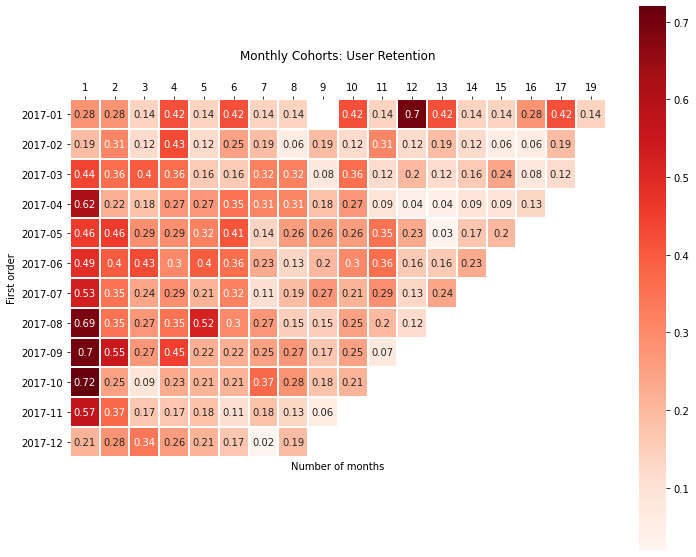

In [249]:
# Построим матрицу удержания в виде тепловой карты

plt.figure(figsize=(12, 10))
ax = sns.heatmap(retention_matrix.drop(columns = [0],axis = 1), annot=True, linewidths=1,square=True, cmap='Reds') 
ax.xaxis.tick_top()
plt.xlabel('Number of months')
plt.ylabel('First order')
plt.title('Monthly Cohorts: User Retention',pad=40)
plt.yticks(rotation = 0)
plt.show()

##### Когорта, сделавших первый заказ 2017-06, имеет самый высокий retentaion на третий месяц - 0.43%

#### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [8]:
# Для выполнения задания нам понадобиться объединить все три датафрейма

full_data = customers.merge(orders, on = ['customer_id']).merge(items, on = ['order_id'])
full_data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [9]:
# Размер датафрейма
full_data.shape

(112650, 18)

In [10]:
# Проверка наличие дубликатов
full_data.drop_duplicates().shape

(112650, 18)

In [11]:
# Отберем для анализа завершенные заказы
full_data = full_data \
    .query('order_status == "delivered" and order_approved_at.isna() == False')

In [12]:
# Cоздадим колонку с датой последнего завершенного заказа + 1 день
control_day= full_data['order_purchase_timestamp'].max() + timedelta(days=1)
control_day

Timestamp('2018-08-30 15:00:37')

In [ ]:
# Найдем время от последнего завершенного заказа до контрольной даты для каждого пользователя 
Recency = full_data \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp': lambda x: (control_day-x.max()).days}) \
    .rename(columns={'order_purchase_timestamp' : 'Recency'}) 

Recency.head()

In [13]:
# Найдем время от последнего завершенного заказа до контрольной даты для каждого пользователя 
Recency = full_data \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp': lambda x: (control_day-x.max()).days}) \
    .rename(columns={'order_purchase_timestamp' : 'Recency'}) 

Recency.head()

,customer_unique_id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115
2,0000f46a3911fa3c0805444483337064,537
3,0000f6ccb0745a6a4b88665a16c9f078,321
4,0004aac84e0df4da2b147fca70cf8255,288


In [14]:
# Общее количество заказов для каждого рользователя
Frequency = full_data.groupby('customer_unique_id', as_index=False) \
    .agg({'order_id' : 'nunique'}) \
    .rename(columns={'order_id' : 'Frequency'})

Frequency.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [316]:
# Постичаем сумму потраченное за все время для каждого пользователя
Monetary = full_data \
    .groupby('customer_unique_id', as_index=False)\
    .agg({'price' : 'sum'}).rename(columns={'price' : 'Monetary'})

Monetary.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


In [331]:
# Объеденим датасеты в один
rfm = Recency.merge(Frequency, on='customer_unique_id').merge(Monetary, on='customer_unique_id')

rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


In [318]:
rfm.describe()

,Recency,Frequency,Monetary
count,93345.000000,93345.000000,93345.000000
mean,237.896599,1.033414,141.623308
std,152.554001,0.209088,215.705007
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.760000
75%,346.000000,1.000000,154.750000
max,714.000000,15.000000,13440.000000


In [319]:
# Каким количеством пользователей сделано определенное количество завершенных заказов

frequency \
    .groupby('frequency') \
    .agg({'frequency':'count'}) \
    .rename(columns={"frequency": "customers"}) \
    .reset_index() \
    .rename(columns={"frequency": "number_of_orders"})

,number_of_orders,customers
0,1,90545
1,2,2572
2,3,181
3,4,28
4,5,9
5,6,5
6,7,3
7,9,1
8,15,1


##### Так как подовляющее количество пользователей сделало 1 заказа,  Разобьем frequency по количеству покупок: 1-1 покупка, 2-2 покупки и более покупок. Остальные параметры разобъем по квинтелям.

In [321]:
# Кластеризуем recency и monetary по квинтелям
quintiles = rfm[['Recency', 'Monetary']].quantile([.2,.4,.6,.8]).to_dict()
quintiles

{'Recency': {0.2: 92.0, 0.4: 177.0, 0.6: 268.0, 0.8: 382.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [341]:
# Программа для задания индекса определенного кластера уникальному пользователю

def r_score(x):
    if x <=quintiles['Recency'][.2]:
        return 5
    elif x<=quintiles['Recency'][.4]:
        return 4
    elif x<=quintiles['Recency'][.6]:
        return 3
    elif x<=quintiles['Recency'][.8]:
        return 2
    else:
        return 1
    
def f_score(x):
    if x==1:
        return 1
    elif x==2:
        return 2
    else: 
        return 3
    
def m_score(x):
    if x<=quintiles['Monetary'][.2]:
        return 1
    elif x<=quintiles['Monetary'][.4]:
        return 2
    elif x<=quintiles['Monetary'][.6]:
        return 3
    elif x<=quintiles['Monetary'][.8]:
        return 4
    else:
        return 5

In [342]:
# Задаем индексы кластеров

rfm['R'] = rfm['Recency'].apply(r_score)
rfm['F'] = rfm['Frequency'].apply(f_score)
rfm['M'] = rfm['Monetary'].apply(m_score)
rfm

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411,promising
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,at risk
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215,at risk
...,...,...,...,...,...,...,...,...,...
93340,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00,1,1,5,115,hibernating
93341,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89,3,1,2,312,cannot loose them
93342,ffff371b4d645b6ecea244b27531430a,568,1,89.90,1,1,3,113,hibernating
93343,ffff5962728ec6157033ef9805bacc48,119,1,115.00,4,1,4,414,promising


In [343]:
# Преобразуем набор индексов кластеров, определенных для уникального пользователя, в строку названия определенного микросегмента

rfm['RFM'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411,promising
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,at risk
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215,at risk


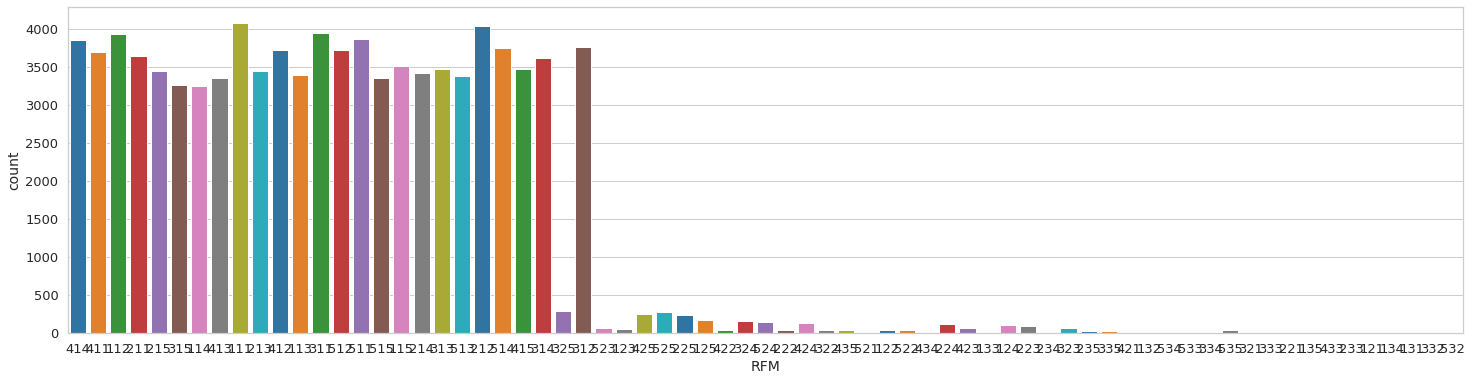

In [384]:
# Визуализируем количество пользователей определенного сегмента

plt.figure(figsize=(25,6))
sns.countplot(rfm.RFM, palette = "tab10")

In [345]:
# Посчитаем количество пользователей каждого сегмента

users_by_segments = rfm \
    .groupby('RFM', as_index=False) \
    .agg({'customer_unique_id': 'count'}) \
    .rename(columns={'customer_unique_id':'users'})
users_by_segments

,RFM,users
0,111,4088
1,112,3942
2,113,3394
3,114,3248
4,115,3519
...,...,...
64,525,286
65,532,1
66,533,6
67,534,3


##### Набор из 49 RFM-сегментов сгруппируем в макросегменты на основе значений R и F

In [359]:
# Сгруппируем в макросегменты
segt_map = {
    r'1[1-3][1-5]': 'hibernating',
    r'2[1-3][1-5]': 'at risk',
    r'3[1-3][1-5]': 'need attention',
    r'[4-5]1[1-5]': 'new customers',
    r'[4-5]2[1-5]': 'potential loyalists',
    r'[4-5]3[1-4]|435': 'loyal customers',
    r'535': 'champions'
}

rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) +  rfm['M'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414,new customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411,new customers
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,at risk
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215,at risk


In [379]:
# Рассчитываем средние значения для каждого макросегмента
rfm_level_agg = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
rfm_level_agg.columns = ['Recency_Mean','Frequency_Mean','Monetary_Mean', 'Count']
rfm_level_agg = rfm_level_agg.sort_values('Count', ascending = False).reset_index()
rfm_level_agg['percentage'] = (rfm_level_agg.Count/rfm_level_agg.Count.sum()).round(4).mul(100)
rfm_level_agg

,Segment,Recency_Mean,Frequency_Mean,Monetary_Mean,Count,percentage
0,new customers,90.6,1.0,140.3,36224,38.81
1,need attention,220.4,1.0,134.1,18709,20.04
2,hibernating,473.3,1.0,140.5,18626,19.95
3,at risk,316.3,1.0,144.6,18577,19.90
4,potential loyalists,89.1,2.0,248.2,1087,1.16
5,loyal customers,120.2,3.3,369.7,72,0.08
6,champions,46.5,3.8,604.4,50,0.05


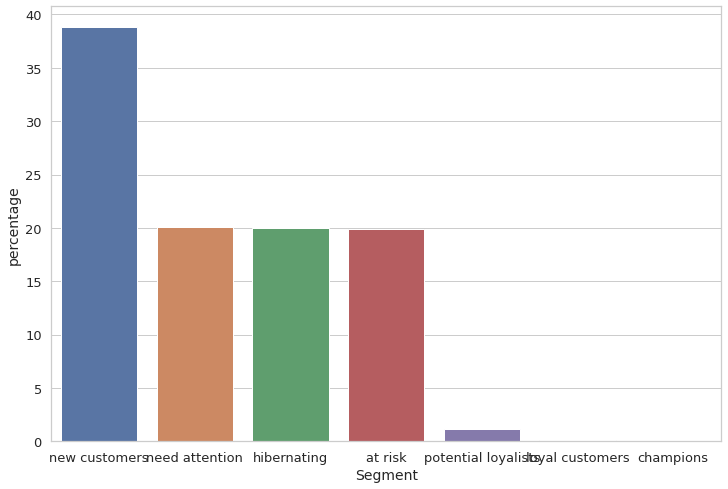

In [383]:
sns.barplot(x='Segment', y='percentage', data=rfm_level_agg)

##### Как видно из полученных данных около 40% процентов пользователей совершили покупку недавно. Около 20 процентов сделали покупка  268-382 дня назада, еще около 20% процентов более 382 дней назад. Потенциальных лояльных покупателей совершивших 2 покупки недавно всего 1.16%. Лояльных и сверхлояльных покупателей неболее 0.13%